In [10]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import torchvision.utils as vutils
import sys

In [11]:
import matplotlib
import numpy
matplotlib.use('Agg')
from matplotlib import pyplot as plt
from torchvision import utils
show_image=False
def imshow(inp, file_name, save=False, title=None):
    """Imshow for Tensor."""
    fig = plt.figure(figsize=(10, 10))
    inp = inp.numpy().transpose((1, 2, 0))
#     inp-=numpy.min(inp)
    plt.imshow(inp)
    plt.savefig(file_name)
    if show_image:
        plt.show()
    else:
        print("Don't show")

In [12]:
z_size=128
hidden_size=512
img_size=28

In [13]:
root = './data'
download = True
trans = transforms.Compose([
    transforms.Scale(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_set = dset.MNIST(
    root=root, train=True, transform=trans, download=download)
test_set = dset.MNIST(root=root, train=False, transform=trans)
batch_size = 128
kwargs = {}
train_loader = torch.utils.data.DataLoader(
    dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    dataset=test_set, batch_size=batch_size, shuffle=False)

In [14]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.model = nn.Sequential(
            nn.Linear(z_size, hidden_size),
            nn.ReLU(True),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(True),
            nn.Linear(hidden_size, img_size**2),
        )
    def forward(self, x):
        x = x.view(x.size()[0], z_size)
        out = self.model(x)
        out = out.view(x.size()[0], 1,img_size,img_size)
        return out

In [15]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.model = nn.Sequential(
            nn.Linear(img_size**2, hidden_size),
            nn.ReLU(True),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(True),
            nn.Linear(hidden_size, 1),
        )
    def forward(self, x):
        out = self.model(x.view(x.size(0), img_size**2))
        out=out.mean(0)
        out = out.view(1)
        return out

In [16]:
one = torch.FloatTensor([1])
noise_holder=torch.FloatTensor(batch_size, z_size, 1, 1)
input_holder = torch.FloatTensor(batch_size, 1, img_size, img_size)
if torch.cuda.is_available():
    one=one.cuda()
    noise_holder.cuda()
    input_holder.cuda()
mone = one * -1

In [17]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

  0%|          | 0/10000 [00:00<?, ?it/s]

show


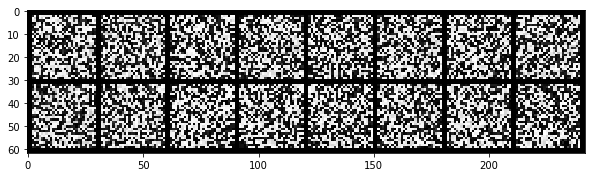

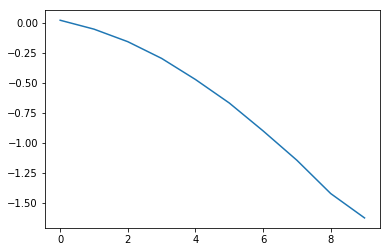

  1%|          | 100/10000 [01:06<1:50:32,  1.49it/s]

show


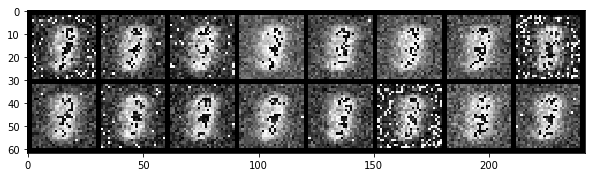

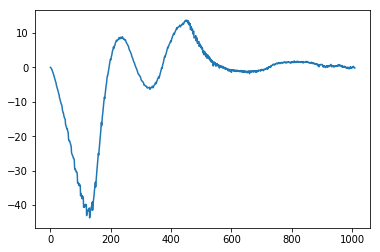

  2%|▏         | 200/10000 [02:07<1:43:57,  1.57it/s]

show


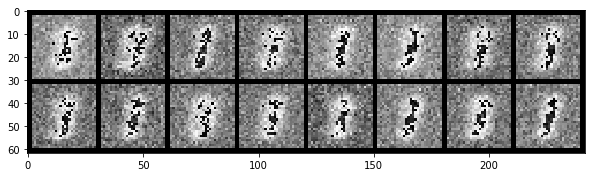

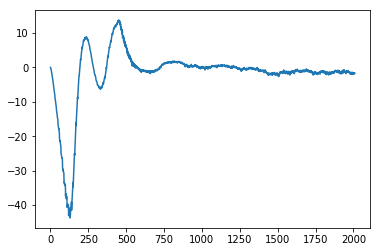

  3%|▎         | 300/10000 [03:09<1:42:10,  1.58it/s]

show


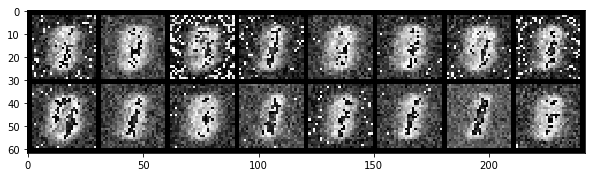

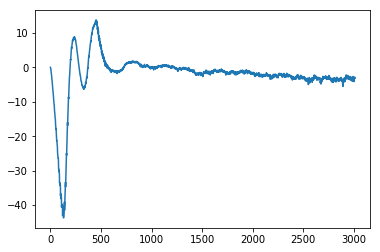

  4%|▍         | 400/10000 [04:10<1:40:02,  1.60it/s]

show


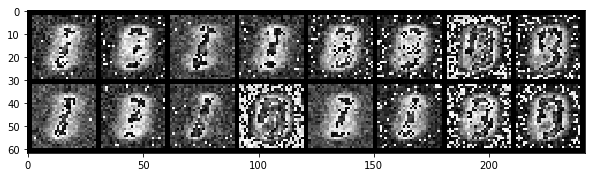

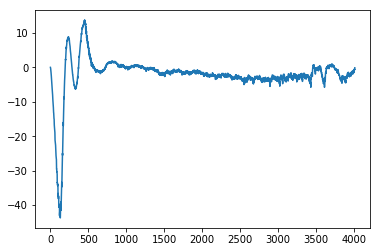

  5%|▌         | 500/10000 [05:04<1:36:16,  1.64it/s]

show


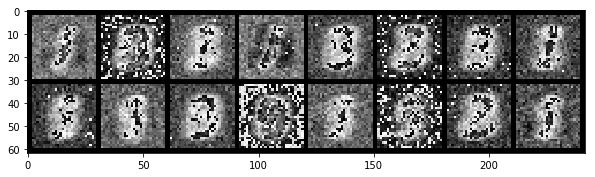

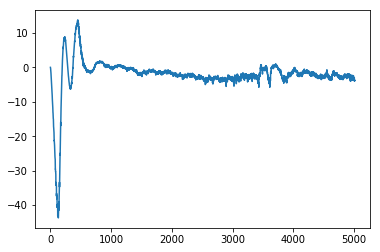

  6%|▌         | 600/10000 [05:56<1:33:01,  1.68it/s]

show


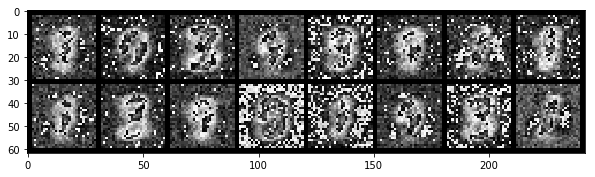

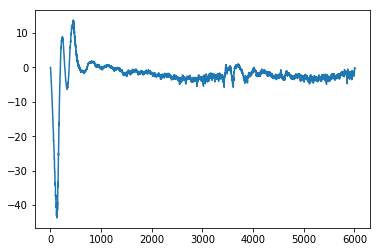

  7%|▋         | 700/10000 [06:50<1:30:48,  1.71it/s]

show


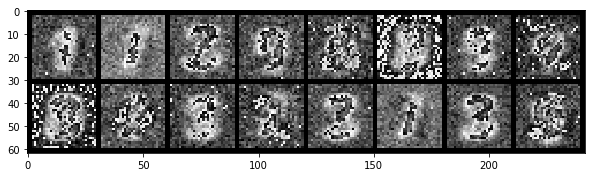

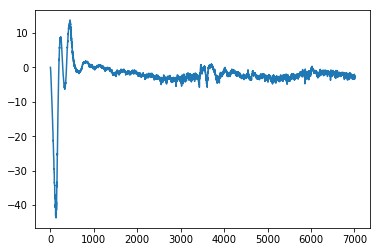

  8%|▊         | 800/10000 [07:49<1:29:57,  1.70it/s]

show


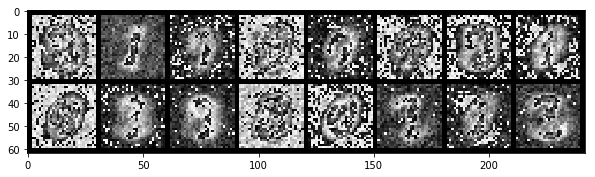

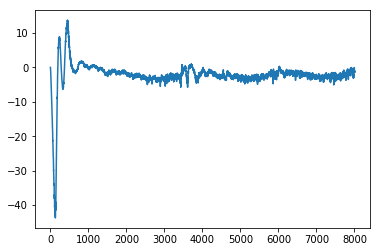

  9%|▉         | 900/10000 [08:43<1:28:11,  1.72it/s]

show


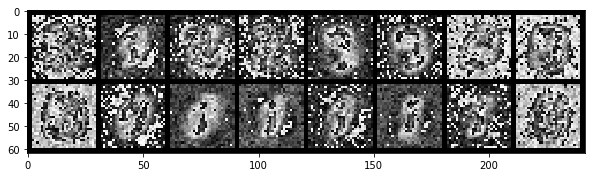

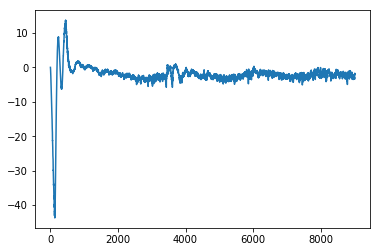

 10%|█         | 1000/10000 [09:40<1:27:01,  1.72it/s]

show


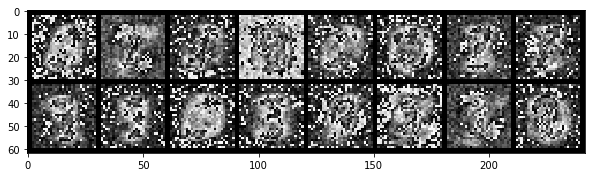

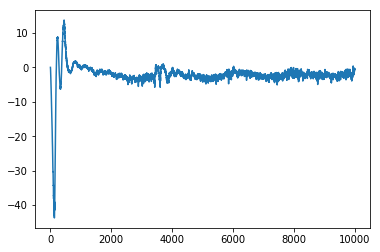

 11%|█         | 1100/10000 [10:34<1:25:33,  1.73it/s]

show


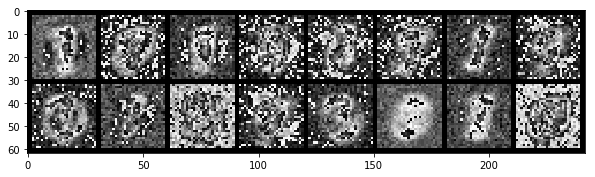

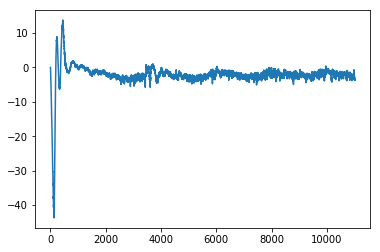

 12%|█▏        | 1200/10000 [11:28<1:24:12,  1.74it/s]

show


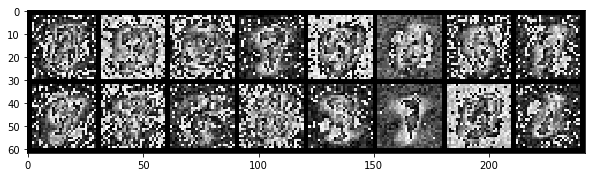

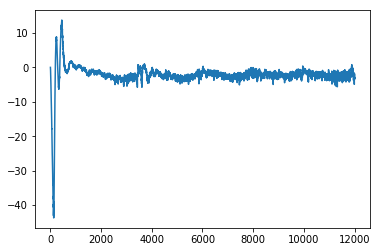

 13%|█▎        | 1300/10000 [12:24<1:23:04,  1.75it/s]

show


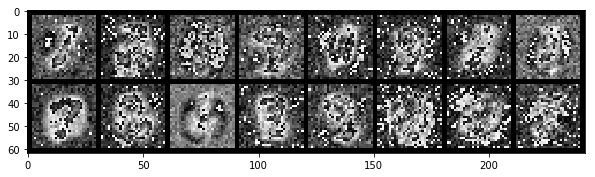

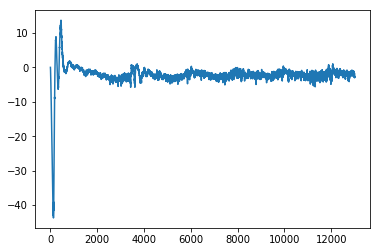

 14%|█▍        | 1400/10000 [13:21<1:22:01,  1.75it/s]

show


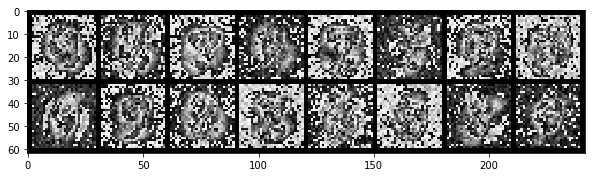

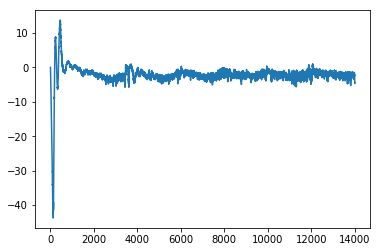

 15%|█▌        | 1500/10000 [14:23<1:21:30,  1.74it/s]

show


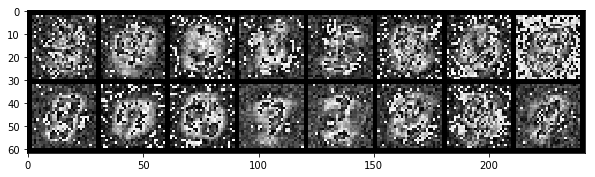

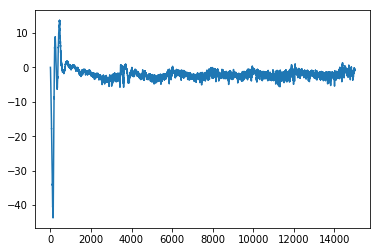

 16%|█▌        | 1600/10000 [15:18<1:20:21,  1.74it/s]

show


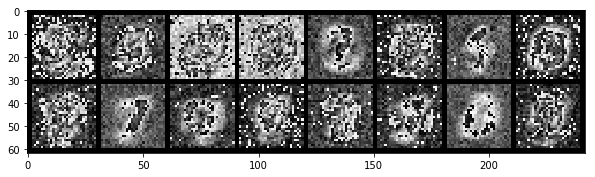

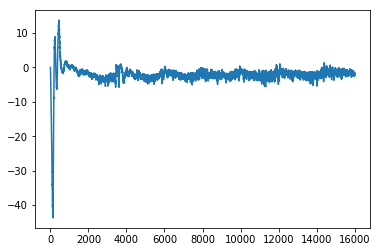

 17%|█▋        | 1700/10000 [16:15<1:19:24,  1.74it/s]

show


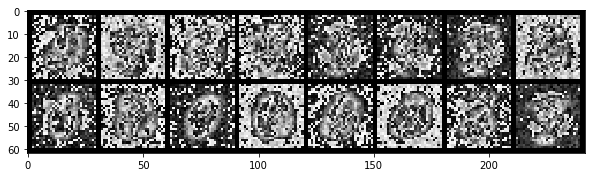

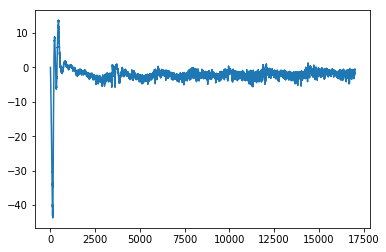

 18%|█▊        | 1800/10000 [17:11<1:18:19,  1.74it/s]

show


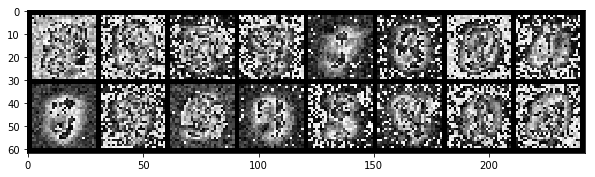

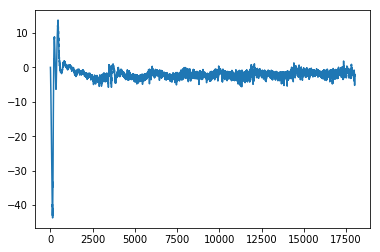

 19%|█▊        | 1870/10000 [17:56<1:17:58,  1.74it/s]

KeyboardInterrupt: 

In [18]:
from tqdm import tqdm
G = Generator()
G.apply(weights_init)
D = Discriminator()
if torch.cuda.is_available():
    G.cuda()
    D.cuda()
G_lr = D_lr = 5e-5
optimizers = {
    'D': torch.optim.RMSprop(D.parameters(), lr=D_lr),
    'G': torch.optim.RMSprop(G.parameters(), lr=G_lr)
}
criterion = nn.BCELoss()
err_Ds=[]
for epoch in tqdm(range(10000)):
    for p in D.parameters():
        p.requires_grad = True
    if epoch<25 or epoch%100==0:
        iter_D=100
    else:
        iter_D=10
    for _ in range(iter_D):
        for p in D.parameters():
            p.data.clamp_(-0.01, 0.01)
        optimizers['D'].zero_grad()
        data=next(iter(train_loader))[0]
        input_holder.resize_as_(data).copy_(data)
        output_real = D(Variable(data))
        output_real.backward(one)
        noise_holder.resize_(data.size()[0], z_size, 1, 1).normal_(0, 1)
        noisev = Variable(noise_holder,volatile=True)
        fake_data = Variable(G(noisev).data)
        output_fake = D(fake_data)
        output_fake.backward(mone)
        err_Ds.append((output_real+output_fake).data.numpy()[0])
        optimizers['D'].step()

    for p in D.parameters():
        p.requires_grad = False
    optimizers['G'].zero_grad()
    noise_holder.resize_(data.size()[0], z_size, 1, 1).normal_(0, 1)
    noisev = Variable(noise_holder)
    fake_data = G(noisev)
    output_fake1 = D(fake_data)
    output_fake1.backward(one)
#     G_loss = -torch.mean(output_fake1)

#     G_loss.backward()
    optimizers['G'].step()

    if epoch % 100 == 0:
        print('show')
        if torch.cuda.is_available():
            dd = utils.make_grid(fake_data.cpu().data[:16])
        else:
            dd = utils.make_grid(fake_data.data[:16])
        imshow(dd,'./results/WGAN_%d.png'%(epoch))
        dd = dd.mul(0.5).add(0.5)
        vutils.save_image(dd, './results/OrWGAN_%d.png'%(epoch))
        plt.plot(err_Ds)
        plt.show()

In [60]:
import torchvision.utils as vutils
data=next(iter(train_loader))[0]
data = data.mul(0.5).add(0.5)
vutils.save_image(data, 'my.png')

In [72]:
err_Ds[0].data.numpy()[0]

0.0023464153